In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(r'/content/Telco_Customer_Churn_Dataset .csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data Cleaning and Preprocessing**

In [4]:
print("Missing values before cleaning:\n", df.isnull().sum())

# Fill missing values (example: for 'TotalCharges')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID (not useful for modeling)
df.drop('customerID', axis=1, inplace=True)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("Data types after encoding:\n", df.dtypes)

Missing values before cleaning:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Data types after encoding:
 gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod   

<ipython-input-4-378f0d53f3bb>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


**Exploratory Data Analysis (EDA)**

Overall Churn Rate: 0.27


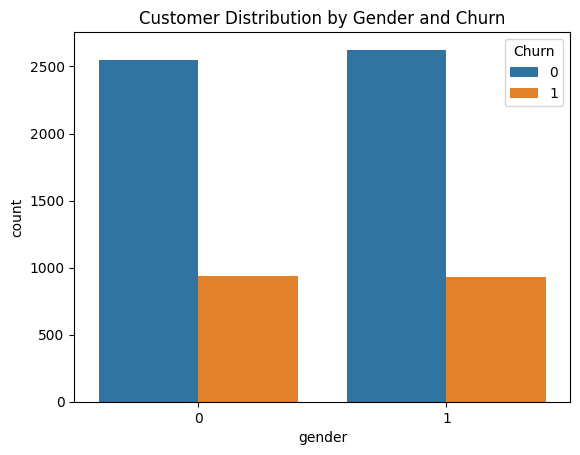

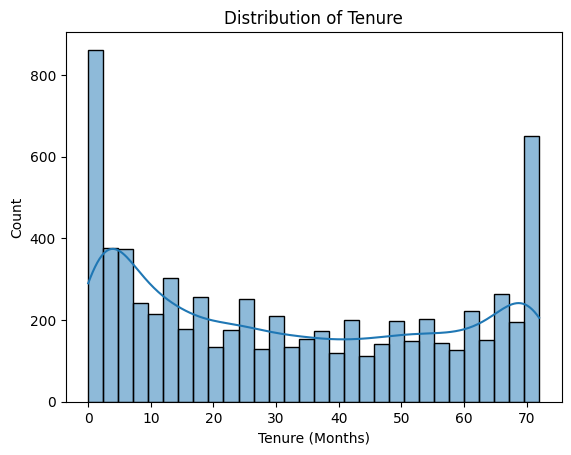

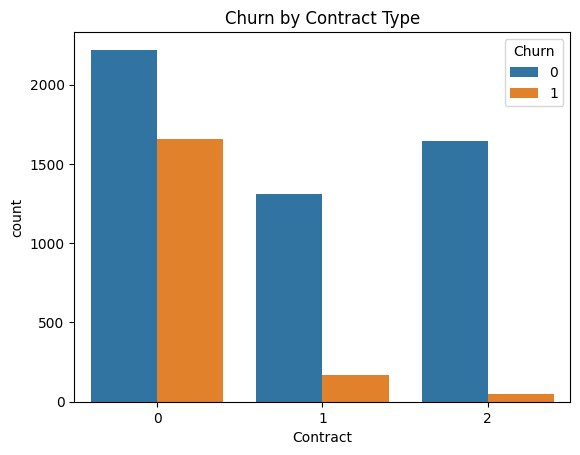

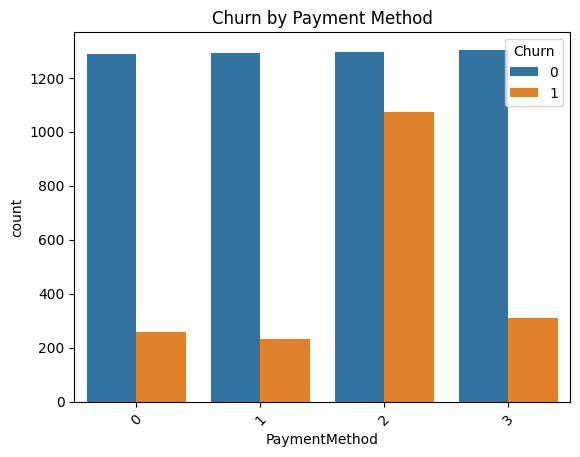

In [5]:
churn_rate = df['Churn'].mean()
print(f"Overall Churn Rate: {churn_rate:.2f}")

# Customer distribution by gender
sns.countplot(data=df, x='gender', hue='Churn')
plt.title('Customer Distribution by Gender and Churn')
plt.show()

# Tenure distribution
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (Months)')
plt.show()

# Churn vs Contract Type
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')
plt.show()

# Churn vs Payment Method
sns.countplot(data=df, x='PaymentMethod', hue='Churn')
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)
plt.show()

**Customer Segmentation**

In [9]:
# --------------------
# Task 3: Customer Segmentation
# --------------------

# Create segments
conditions = [
    (df['tenure'] <= 12),
    (df['tenure'] > 12) & (df['tenure'] <= 24),
    (df['tenure'] > 24)
]
choices = ['New', 'Intermediate', 'Loyal']
df['TenureGroup'] = np.select(conditions, choices, default='Unknown')

# Encode 'TenureGroup'
df['TenureGroup'] = le.fit_transform(df['TenureGroup'])

# Segment analysis
segment_churn = df.groupby('TenureGroup')['Churn'].mean()
print("Churn Rate by Tenure Group:\n", segment_churn)

# Monthly Charges segmentation
df['HighCharges'] = df['MonthlyCharges'] > df['MonthlyCharges'].median()


Churn Rate by Tenure Group:
 TenureGroup
0    0.287109
1    0.140360
2    0.474382
Name: Churn, dtype: float64


**Churn Prediction Model**

In [10]:
# Features and label
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1036
           1       0.68      0.56      0.62       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409

Confusion Matrix:
 [[937  99]
 [163 210]]
Accuracy Score: 0.8140525195173882


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Customer Retention Strategies**

In [12]:
#Key churn factors (feature importance)
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print("Top Factors Influencing Churn:\n", importance.head(10))

# Customer Lifetime Value (simple calculation)
# LTV = MonthlyCharges * Tenure

df['LTV'] = df['MonthlyCharges'] * df['tenure']

# High-value at-risk customers
high_value_at_risk = df[(df['LTV'] > df['LTV'].median()) & (df['Churn'] == 1)]
print(f"High-value customers at risk of churning: {high_value_at_risk.shape[0]}")

Top Factors Influencing Churn:
 PaperlessBilling    0.367230
TenureGroup         0.274840
InternetService     0.204782
SeniorCitizen       0.182194
HighCharges         0.155202
MultipleLines       0.080152
Partner             0.063810
StreamingMovies     0.039583
PaymentMethod       0.038271
MonthlyCharges      0.020152
dtype: float64
High-value customers at risk of churning: 661


**  Visualisation**

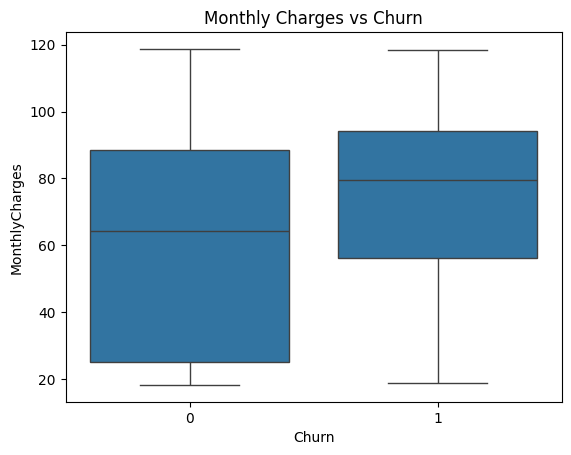

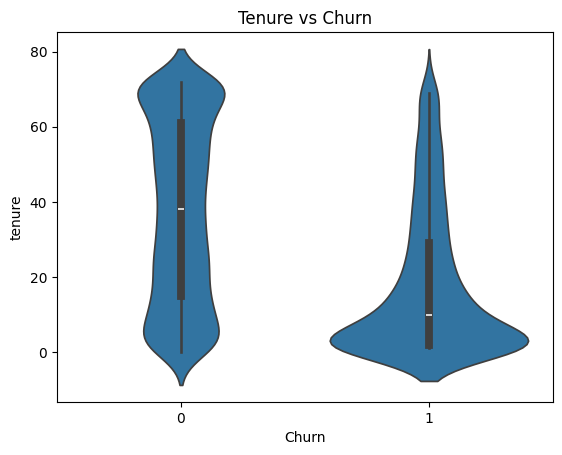

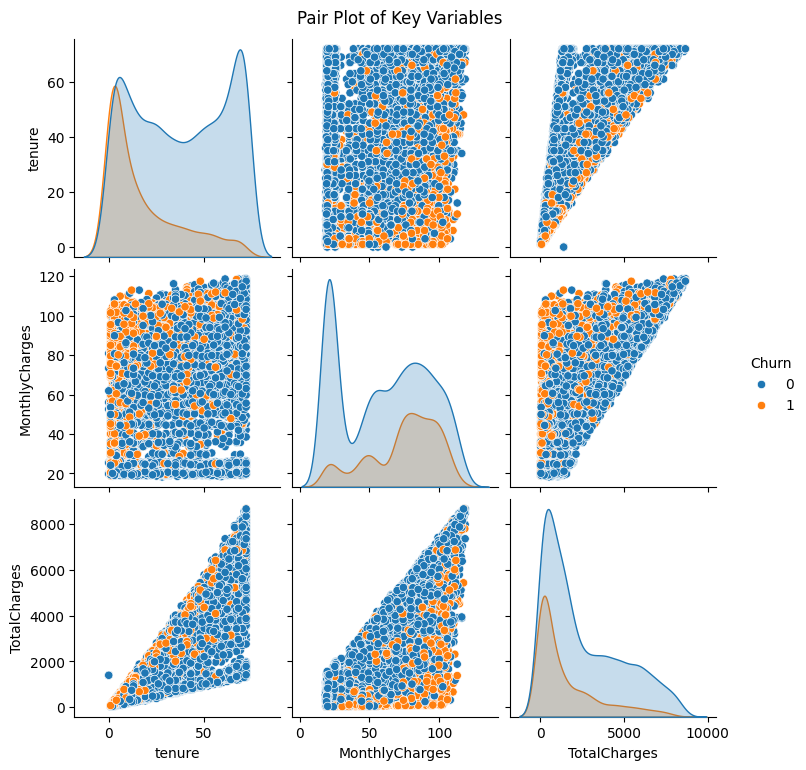

All tasks completed successfully! 🚀


In [13]:
# Boxplot - Monthly Charges by Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

# Violin plot - Tenure by Churn
sns.violinplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.show()

# Pair plot
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')
plt.suptitle('Pair Plot of Key Variables', y=1.02)
plt.show()